In [1]:
#bhv_train.csv，训练集数据，包含脱敏后的客户行为数据。
#cust_train.csv，训练集数据，脱敏后的客户基本情况信息。
#train_label.csv，训练集数据，包含脱敏后的客户ID（客户唯一识别号）和相应label（标签）。
#loan_train.csv，训练集数据，脱敏后的客户贷款数据。
#trans_train.csv，训练集数据，脱敏后的客户交易信息。
#asset_train.csv，训练集数据，脱敏后的客户资产信息。
import warnings
import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
warnings.simplefilter('ignore')
# 读取训练数据
ass_train = pd.read_csv('../input/赛题A_预赛数据/训练集/asset_train.csv')
bhv_train = pd.read_csv('../input/赛题A_预赛数据/训练集/bhv_train.csv')
cust_train = pd.read_csv('../input/赛题A_预赛数据/训练集/cust_train.csv')
train_label = pd.read_csv('../input/赛题A_预赛数据/训练集/train_label.csv')
loan_train = pd.read_csv('../input/赛题A_预赛数据/训练集/loan_train.csv')
trans_train = pd.read_csv('../input/赛题A_预赛数据/训练集/trans_train.csv')

ass_test = pd.read_csv('../input/赛题A_预赛数据/测试集/asset_test.csv')
bhv_test = pd.read_csv('../input/赛题A_预赛数据/测试集/bhv_test.csv')
cust_test = pd.read_csv('../input/赛题A_预赛数据/测试集/cust_test.csv')
loan_test = pd.read_csv('../input/赛题A_预赛数据/测试集/loan_test.csv')
trans_test = pd.read_csv('../input/赛题A_预赛数据/测试集/trans_test.csv')

In [53]:
train = cust_train.merge(train_label, on = 'id', how = 'left')
train = train.merge(ass_train, on = 'id', how = 'left')
train = train.merge(bhv_train, on = 'id', how = 'left')
train = train.merge(loan_train, on = 'id', how = 'left')
train = train.merge(trans_train, on = 'id', how = 'left')

test = cust_test.merge(ass_test, on = 'id', how = 'left')
test = test.merge(bhv_test, on = 'id', how = 'left')
test = test.merge(loan_test, on = 'id', how = 'left')
test = test.merge(trans_test, on = 'id', how = 'left')

data = train.append(test).reset_index(drop=True)
print(test.shape)
print(data['label'].isna().sum())

(3600, 55)
3600


In [54]:
drop_cols = ['id','label']
for f in data.columns:
    if data[f].nunique() < 2:
        drop_cols.append(f)
        print(f)
    if data[~data[f].isna()][f].value_counts().values[0] / data[~data[f].isna()].shape[0] > 0.99:
        drop_cols.append(f)
        print(f)

a12
a15
a36
a36
a37
a39


In [55]:
cat_f = ['a1','a4']
for f in cat_f:
    data[f] = data[f].astype(str)
    le = LabelEncoder()
    data[f] = le.fit_transform(data[f])
data.head()

,id,a1,a2,a3,a4,a5,a6,a7,a8,a9,...,a26,a27,a28,a29,a30,a31,a32,a33,a34,a35
0,532032d9e16e123c4885236cf1fc2d1e,2,67.0,4.0,5,0,0,0.0,1,0,...,0.0,0.0,0.0000,0.0,0,0,0.00,0.0,0,0
1,3fcdc734dc2fefa8acb0bf4f48e8fcf4,2,3.0,4.0,5,0,0,0.0,0,0,...,0.0,0.0,0.0000,0.0,0,0,0.00,0.0,0,0
2,02ec6569f2679be5dfc3d075a1ccf87b,2,2.0,5.0,5,0,0,0.0,4,0,...,0.0,0.0,9971.6208,9500.0,2,1,177.56,0.0,1,0
3,888c49cb3235fa8eaede9ad4c68aa6a1,1,70.0,1.0,5,0,0,0.0,4,0,...,0.0,0.0,0.0000,0.0,0,0,103500.00,94500.0,1,1
4,9994690c6eb5faa7805944d5de3e69bc,1,8.0,6.0,5,0,0,0.0,0,0,...,0.0,0.0,0.0000,0.0,0,0,0.00,0.0,0,0


In [56]:
data['a51/a49'] = data['a51'] / (data['a49']+1e-5)
data['a49/a50'] = data['a49'] / (data['a50']+1e-5)

data['a54/a52'] = data['a54'] / (data['a52']+1e-5)
data['a52/a53'] = data['a52'] / (data['a53']+1e-5)


data['a54/a51'] = data['a54'] / (data['a51']+1e-5)
data['a53/a50'] = data['a53'] / (data['a50']+1e-5)
data['a52/a49'] = data['a52'] / (data['a49']+1e-5)

In [57]:
test_df = data[data["label"].isnull() == True].copy().reset_index(drop=True)
train_df = data[~data["label"].isnull() == True].copy().reset_index(drop=True)

In [58]:
feature_name = [f for f in data.columns if f not in drop_cols]

In [59]:
X_train = train_df[feature_name].reset_index(drop=True)
X_test = test_df[feature_name].reset_index(drop=True)
y = train_df['label'].reset_index(drop=True)
print(len(feature_name))
print(feature_name)

56
['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a13', 'a14', 'a16', 'a17', 'a49', 'a50', 'a51', 'a52', 'a53', 'a54', 'a38', 'a40', 'a41', 'a42', 'a43', 'a44', 'a45', 'a46', 'a47', 'a48', 'a18', 'a19', 'a20', 'a21', 'a22', 'a23', 'a24', 'a25', 'a26', 'a27', 'a28', 'a29', 'a30', 'a31', 'a32', 'a33', 'a34', 'a35', 'a51/a49', 'a49/a50', 'a54/a52', 'a52/a53', 'a54/a51', 'a53/a50', 'a52/a49']


In [60]:
train_pred = {}
test_pred = {}

In [61]:
# seeds = [2222, 5, 4, 2, 209, 4096, 2048, 1024, 2015, 1015, 820]#11
seeds = [2]#2
num_model_seed = 1
oof = np.zeros(X_train.shape[0])
prediction = np.zeros(X_test.shape[0])
feat_imp_df = pd.DataFrame({'feats': feature_name, 'imp': 0})
parameters = {
    'learning_rate': 0.008,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 63,
    'feature_fraction': 0.8,#原来0.8
    'bagging_fraction': 0.8,
    'bagging_freq': 5,#5
    'seed': 2,
    'bagging_seed': 1,
    'feature_fraction_seed': 7,
    'min_data_in_leaf': 20,
    'verbose': -1, 
    'n_jobs':4
}
fold = 5
for model_seed in range(num_model_seed):
    print(seeds[model_seed],"--------------------------------------------------------------------------------------------")
    oof_cat = np.zeros(X_train.shape[0])
    prediction_cat = np.zeros(X_test.shape[0])
    skf = StratifiedKFold(n_splits=fold, random_state=seeds[model_seed], shuffle=True)
    for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
        train_x, test_x, train_y, test_y = X_train[feature_name].iloc[train_index], X_train[feature_name].iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        dtrain = lgb.Dataset(train_x, label=train_y)
        dval = lgb.Dataset(test_x, label=test_y)
        lgb_model = lgb.train(
            parameters,
            dtrain,
            num_boost_round=10000,
            valid_sets=[dval],
            early_stopping_rounds=100,
            verbose_eval=100, )
        oof_cat[test_index] += lgb_model.predict(test_x,num_iteration=lgb_model.best_iteration)
        prediction_cat += lgb_model.predict(X_test,num_iteration=lgb_model.best_iteration) / fold
        feat_imp_df['imp'] += lgb_model.feature_importance()

        del train_x
        del test_x
        del train_y
        del test_y
        del lgb_model
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
gc.collect()

2 --------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.871913
[200]	valid_0's auc: 0.871986
Early stopping, best iteration is:
[119]	valid_0's auc: 0.873128
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.887323
[200]	valid_0's auc: 0.888594
[300]	valid_0's auc: 0.887836
Early stopping, best iteration is:
[265]	valid_0's auc: 0.889287
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.910612
Early stopping, best iteration is:
[89]	valid_0's auc: 0.910952
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.885308
[200]	valid_0's auc: 0.883941
Early stopping, best iteration is:
[102]	valid_0's auc: 0.885622
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.879833
[200]	valid_0's auc: 0.88053
Early stopping, best iteration is:
[1

2714

In [62]:
print(feat_imp_df.sort_values('imp', ascending=False)[:20])

      feats   imp
1        a2  2848
2        a3  2383
50  a49/a50  2218
52  a52/a53  1941
7        a8  1928
54  a53/a50  1877
51  a54/a52  1790
38      a25  1772
49  a51/a49  1726
55  a52/a49  1641
3        a4  1607
53  a54/a51  1598
17      a51  1393
16      a50  1360
46      a33  1328
15      a49  1304
41      a28  1241
20      a54  1222
19      a53  1220
29      a47  1115


In [63]:
train_pred['lgb'] = oof
test_pred['lgb'] = prediction

In [64]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
print("lgb train auc: ", roc_auc_score(y, train_pred['lgb']))

lgb train auc:  0.8796560414642047


In [65]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.1,0.9,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (train_pred['lgb'].reshape((-1)) > threshold).astype('int')
    m = f1_score(y.values.reshape((-1)), preds, average='binary')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 

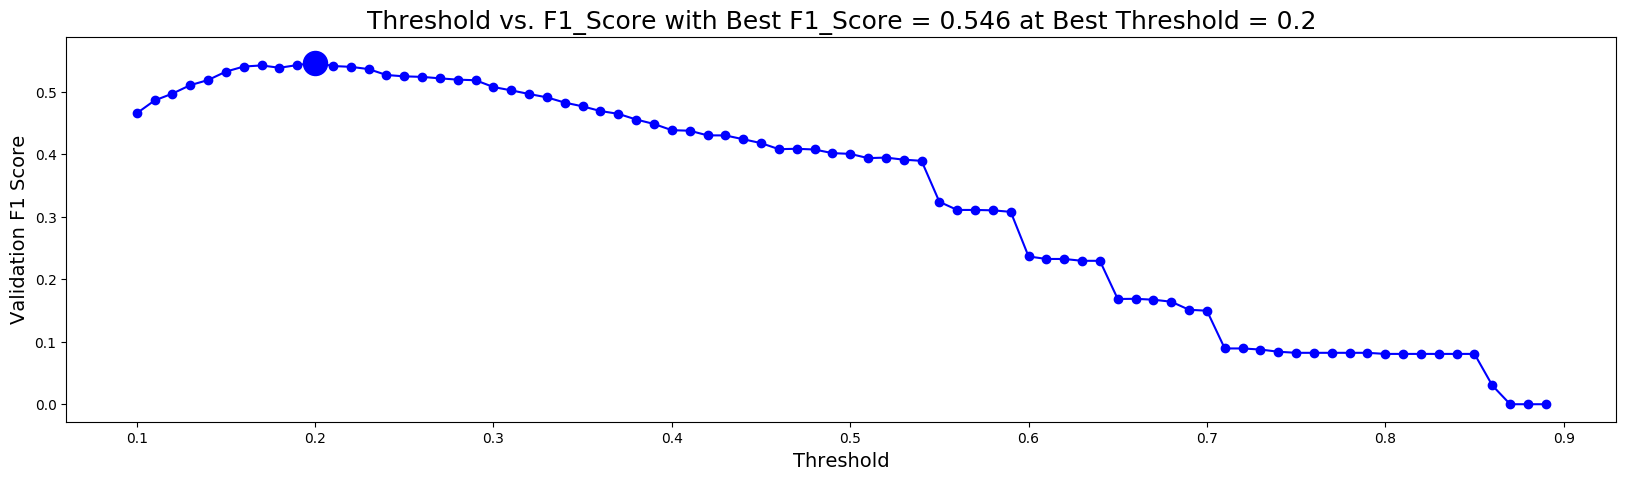

In [66]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [67]:
auc = roc_auc_score(y, train_pred['lgb'])
f1 = best_score
print(auc*0.3 + f1*0.7)

0.6461598093811574


In [68]:
label=[1 if x >= best_threshold else 0 for x in prediction]
np.sum(label)

548

In [69]:
sub = test[['id']]
sub['pred_prob'] = prediction
sub['pred_label'] = label
sub.head()

,id,pred_prob,pred_label
0,9bb9cdf5c620d3e544ecc40c323891e7,0.060227,0
1,4df9fa2db089bfdfd3c0f6fb480d7081,0.244078,1
2,f700afd6a245cd5deadd7d23ae91bc76,0.062661,0
3,4ee4f29b6bdacb6432175fe1a695580b,0.049155,0
4,bda4cef7762b3fb7531f426659c8a160,0.134805,0


In [70]:
sub.to_csv('/home/workspace/output/submit.csv',index=0)

In [ ]:
! castlecli --third local --token xxxx --source /home/workspace/output/submit.csv